In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset = pd.read_csv('A2Q1.csv',delimiter=',',header=None)
dataset = dataset.values

### QUESTION 1 (i)
We will consider a bernoulli distribution with each cluster $k$ having parameter $p_k$ of dimension $D$
- The likelihood is computed as :
    
    $\prod_{i=1}^{n}\sum_{k=1}^{K}(\pi_k.(\prod_{d=1}^{D}p_{k,d}^{x_{i,d}}.(1-p_{k,d})^{1-x_{i,d}}))$

    
        
- Lambda at Expectation step is calculated as :
        
    $\lambda_{i}^{k} = \frac{(\pi_k.(\prod_{d=1}^{D}p_{k,d}^{x_{i,d}}.(1-p_{k,d})^{1-x_{i,d}}))}{\sum_{k=1}^{K}(\pi_k.(\prod_{d=1}^{D}p_{k,d}^{x_{i,d}}.(1-p_{k,d})^{1-x_{i,d}}))}$


- $\pi_k$ is calculated at Maximisation step as :

    $\pi_k = \frac{\sum_{i=1}^{N}\lambda_{i}^{k}}{N}$


- $p_{k}$ is calculated at Maximisation step as :
    
    $p_{k} = \frac{\sum_{i=1}^{N}\lambda_{i}^{k}.x_i}{\sum_{i=1}^{N}\lambda_{i}^{k}}$



In [2]:
# We calculate 
def bernoulli(p_d,x_d):
    D = len(x_d) # number of features
    P = 1 # probability of the data point

    for d in range(D):
        if x_d[d] == 1:
            P *= p_d[d]
        else:
            P *= 1-p_d[d]
    return P

def E_step(theta_pi, theta_p_d, dataset):
    N = len(dataset) # number of data points
    K = len(theta_pi) # number of clusters

    lamb = np.array([[0.0]*K]*N)
    for i in range(N):
        for k in range(K):
            lamb[i][k] = theta_pi[k]*bernoulli(theta_p_d[k],dataset[i])
        lamb[i] = lamb[i]/sum(lamb[i])
    return lamb # n x k

def M_step(lamb, dataset):
    N = len(dataset) # number of data points
    D = len(dataset[0]) # number of features
    K = len(lamb[0]) # number of clusters

    theta_p_d = np.array([[0.0]*D]*K)
    theta_pi = np.array([0.0]*K)

    for k in range(K):
        theta_pi[k] = sum(lamb[i][k] for i in range(N))/N
        theta_p_d[k] = sum(lamb[i][k]*dataset[i] for i in range(N))/sum(lamb[i][k] for i in range(N))
    return theta_pi, theta_p_d

In [3]:
def EM_algo(dataset,K):
    K = K # number of clusters
    D = len(dataset[0]) # number of features
    N = len(dataset) # number of data points
    
    # Step 1: Initialize the parameters
    theta_pi = np.random.rand(K) 
    theta_pi = theta_pi/sum(theta_pi) # sum of all the pi's should be 1
    theta_p_d = np.random.rand(K,D) 

    t_log_likelihood = [] # log likelihood at each iteration
    
    # Calculate the log likelihood at initialisation
    log_like = np.sum(np.log(np.sum(theta_pi[k]*bernoulli(theta_p_d[k],dataset[i]) for k in range(K))) for i in range(N))
    t_log_likelihood.append(log_like)

    iter = 15 # number of iterations
    while iter :
        # Step 2: E-step
        lamb = E_step(theta_pi, theta_p_d, dataset)
        # Step 3: M-step
        theta_pi, theta_p_d = M_step(lamb, dataset)

        # Calculate the log likelihood at each iteration
        log_like = np.sum(np.log(np.sum(theta_pi[k]*bernoulli(theta_p_d[k],dataset[i]) for k in range(K))) for i in range(N))
        t_log_likelihood.append(log_like)

        iter -= 1
        # Check for convergence/tolerance for termination
        if np.linalg.norm(lamb - E_step(theta_pi, theta_p_d, dataset)) < 1e-6:
            break
        
    while iter :
        t_log_likelihood.append(log_like)
        iter -= 1
    return t_log_likelihood

C:\Users\Arjun\AppData\Local\Temp\ipykernel_23964\1782889788.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_like = np.sum(np.log(np.sum(theta_pi[k]*bernoulli(theta_p_d[k],dataset[i]) for k in range(K))) for i in range(N))
C:\Users\Arjun\AppData\Local\Temp\ipykernel_23964\1782889788.py:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_like = np.sum(np.log(np.sum(theta_pi[k]*bernoulli(theta_p_d[k],dataset[i]) for k in range(K))) for i in range(N))


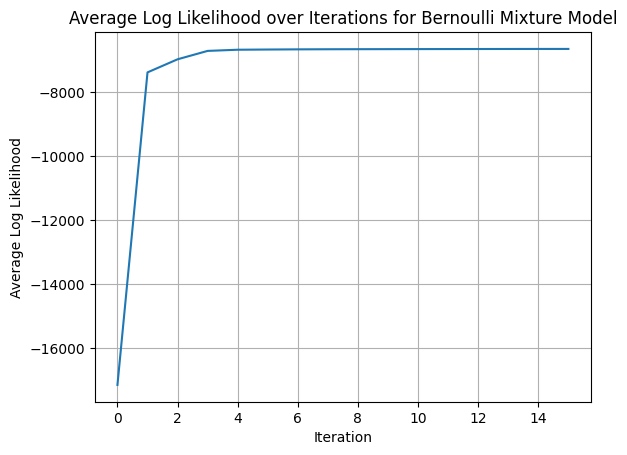

In [4]:
def plot_log_likely(dataset,k):
    #EM Algorithm
    all_log_like = []
    for i in range(1):
        log_like = EM_algo(dataset,k)
        all_log_like.append(log_like)
    avg_log_like = np.mean(all_log_like,axis=0)

    plt.plot(avg_log_like)
    plt.title('Average Log Likelihood over Iterations for Bernoulli Mixture Model')
    plt.xlabel('Iteration')
    plt.ylabel('Average Log Likelihood')
    plt.grid(True)

K = 4
plot_log_likely(dataset,K)

###  QUESTION 1 (ii)
We will perform EM algorithm with gaussian mixture


In [5]:
# We calculate 
def gaussian(mean_d, covar_mat, x_d):
    TOLERANCE = 1e-70
    D = len(x_d) # number of features
    covar = np.array(covar_mat)
    det_cov = np.linalg.det(covar)
    if det_cov == 0:
        I = np.identity(D)
        lam = TOLERANCE
        covar = covar + lam*I
    
    term_a = 1/(((2*np.pi)**(D/2))*((det_cov+TOLERANCE)**0.5))
    term_exp = -0.5*np.matmul(np.matmul((x_d-mean_d),np.linalg.inv(covar)),(x_d-mean_d).T)
    P = term_a*np.exp(term_exp)
    return P

def E_step_gauss(lamb,theta_pi, theta_mean, theta_covar, dataset):
    N = len(dataset) # number of data points
    K = len(theta_pi) # number of clusters

    for i in range(N):
        sum_lamb = 0
        for k in range(K):
            lamb[i][k] = theta_pi[k]*gaussian(theta_mean[k],theta_covar[k], dataset[i])
            sum_lamb += lamb[i][k]
        lamb[i] = lamb[i]/sum_lamb
    return

def M_step_gauss(lamb, theta_pi, theta_mean, theta_covar, dataset):
    N = len(dataset) # number of data points
    D = len(dataset[0]) # number of features
    K = len(lamb[0]) # number of clusters

    for k in range(K):
        theta_pi[k] = np.sum([lamb[i][k] for i in range(N)])/N
        theta_mean[k] = np.sum([lamb[i][k]*dataset[i] for i in range(N)])/np.sum(lamb[i][k] for i in range(N))
        theta_covar[k] = np.sum(lamb[i][k]*np.outer(dataset[i]-theta_mean[k],dataset[i]-theta_mean[k]) for i in range(N))/np.sum(lamb[i][k] for i in range(N))
    return

In [6]:
def EM_algo_gauss(dataset,K):
    K = K # number of clusters
    D = len(dataset[0]) # number of features
    N = len(dataset) # number of data points
    
    # Step 1: Initialize the parameters
    theta_pi = np.random.rand(K) 
    theta_pi = theta_pi/sum(theta_pi) # sum of all the pi's should be 1
    indicator = np.array([0]*N)
    for i in range(N):
        indicator[i] = np.random.randint(0,K)
    theta_mean = np.array([[0.0]*D]*K)
    theta_covar = np.array([[[0.0]*D]*D]*K)
    for k in range(K):
        theta_mean[k] = np.mean(dataset[indicator==k],axis=0)
        theta_covar[k] = np.cov(dataset[indicator==k].T)
    lamb = np.array([[0.0]*K]*N)


    t_log_likelihood = [] # log likelihood at each iteration
    
    # Calculate the log likelihood at initialisation
    log_like = np.sum(np.log(np.sum(theta_pi[k]*gaussian(theta_mean[k],theta_covar[k],dataset[i]) for k in range(K))) for i in range(N))
    t_log_likelihood.append(log_like)

    iter = 15 # number of iterations
    while iter :
        # Step 2: E-step
        E_step_gauss(lamb, theta_pi, theta_mean, theta_covar, dataset)
        # Step 3: M-step
        M_step_gauss(lamb, theta_pi, theta_mean, theta_covar, dataset)

        # Calculate the log likelihood at each iteration
        log_like = np.sum(np.log(np.sum(theta_pi[k]*gaussian(theta_mean[k],theta_covar[k],dataset[i]) for k in range(K))) for i in range(N))
        t_log_likelihood.append(log_like)

        iter -= 1
    return t_log_likelihood

C:\Users\Arjun\AppData\Local\Temp\ipykernel_23964\3508939273.py:23: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_like = np.sum(np.log(np.sum(theta_pi[k]*gaussian(theta_mean[k],theta_covar[k],dataset[i]) for k in range(K))) for i in range(N))
C:\Users\Arjun\AppData\Local\Temp\ipykernel_23964\3508939273.py:34: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_like = np.sum(np.log(np.sum(theta_pi[k]*gaussian(theta_mean[k],theta_covar[k],dataset[i]) for k in range(K))) for i in range(N))


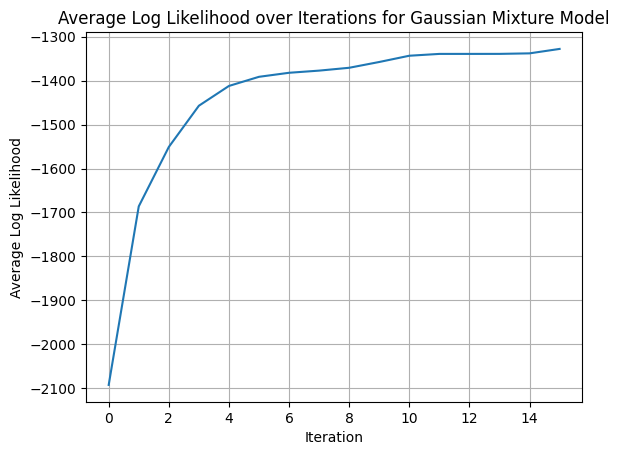

In [7]:
def plot_log_likely_gaussian(dataset,k):
    #EM Algorithm
    all_log_like = []
    for i in range(1):
        log_like = EM_algo_gauss(dataset,k)
        all_log_like.append(log_like)
    avg_log_like = np.mean(all_log_like,axis=0)

    plt.plot(avg_log_like)
    plt.title('Average Log Likelihood over Iterations for Gaussian Mixture Model')
    plt.xlabel('Iteration')
    plt.ylabel('Average Log Likelihood')
    plt.grid(True)

K = 4
plot_log_likely_gaussian(dataset,K)

In [8]:
import random
# K means on the dataset with K = 4
def Recalculate_means(Z, dataset, means):
    for i in range(means.shape[0]):
        cluster = dataset[Z==i]
        if cluster.shape[0] != 0:
            means[i] = np.mean(cluster, axis=0)
    return means       

def Initialize_k_means (dataset, k):
    n = dataset.shape[0]
    Z = np.array([random.randint(0,k-1) for i in range(n)]) # Randomly assigning clusters
    means = Recalculate_means(Z, dataset, np.zeros((k,dataset.shape[1])))
    return Z, means

def MSE(x, mean):
    return np.linalg.norm(x-mean)**2

def Reassign_clusters(Z, dataset, means):
    flag = 0
    for i in range(dataset.shape[0]):
        mean = means[Z[i]]
        for j in range(means.shape[0]):
            if MSE(dataset[i], means[j]) < MSE(dataset[i], mean):
                Z[i] = j
                mean = means[j]
                flag = 1
    if flag == 0:
        return Z, 0 # No change in clusters
    else:
        return Z, 1 # Change in clusters

def KMeans(dataset, k,random_init = True, Z = None, means = None):
    if(random_init): Z,means = Initialize_k_means(dataset, k)
    flag = 1 # Flag to check if clusters have changed
    errors = []
    while flag:
        errors.append(sum(MSE(dataset[i], means[(int)(Z[i])]) for i in range(dataset.shape[0])))
        Z, flag = Reassign_clusters(Z, dataset, means)
        means = Recalculate_means(Z, dataset, means)
    return Z, means, errors

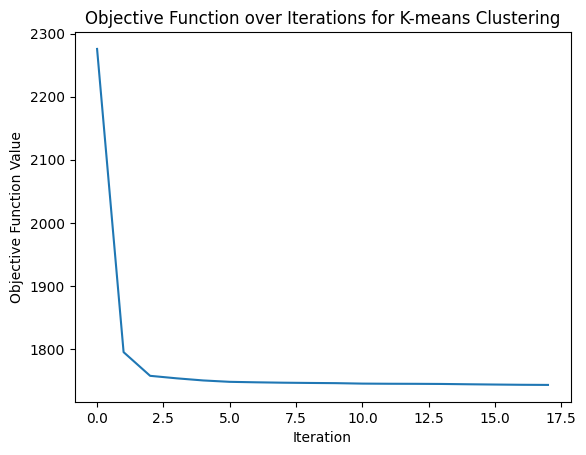

: 

In [9]:
Z,_,obj = KMeans(dataset,4)
plt.plot(obj)
plt.title('Objective Function over Iterations for K-means Clustering')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.show()